In [5]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
MERGED_DATASET_FILEPATH = Path("data/dataset.csv")

In [7]:
df = pd.read_csv(MERGED_DATASET_FILEPATH, parse_dates=["Date"], index_col="Date")
df.head()

,PBG,OPL,ACP,PEO,PXM,PGN,PKN,LTS,AGO,BIO,PKO,KGH,MBK,CPS,GTN,GTC,CEZ,SPL
Date,,,,,,,,,,,,,,,,,,
2008-05-07,0.027439,0.004516,0.008777,0.026825,0.025710,0.002412,0.000233,0.016224,-0.007332,0.029851,0.028052,0.029334,0.037730,0.004889,0.011982,0.040209,0.008851,0.044528
2008-05-08,-0.025154,-0.008568,-0.016642,-0.037460,0.009734,-0.009557,-0.000732,-0.022903,-0.022126,-0.014493,-0.014020,0.003690,-0.028561,-0.004006,-0.007877,0.001312,-0.012147,-0.005629
2008-05-09,0.000000,0.005904,0.005871,0.010213,-0.020666,-0.007186,0.003097,-0.024020,-0.008766,-0.014706,0.003180,-0.034807,-0.002676,-0.023465,0.019825,-0.014157,-0.000582,0.017058
2008-05-12,0.025803,0.017523,0.008769,0.011840,0.005599,0.024230,0.001859,0.018189,0.008844,0.000000,0.002957,0.012318,0.004548,0.000785,0.019439,0.028688,-0.004772,0.006308
2008-05-13,-0.012254,-0.006939,-0.014478,0.017642,-0.015387,0.000000,0.001690,0.002990,0.002495,-0.014925,0.008024,0.011288,0.000814,0.011564,0.003842,0.050797,-0.023708,0.004941


## Plot of daily returns

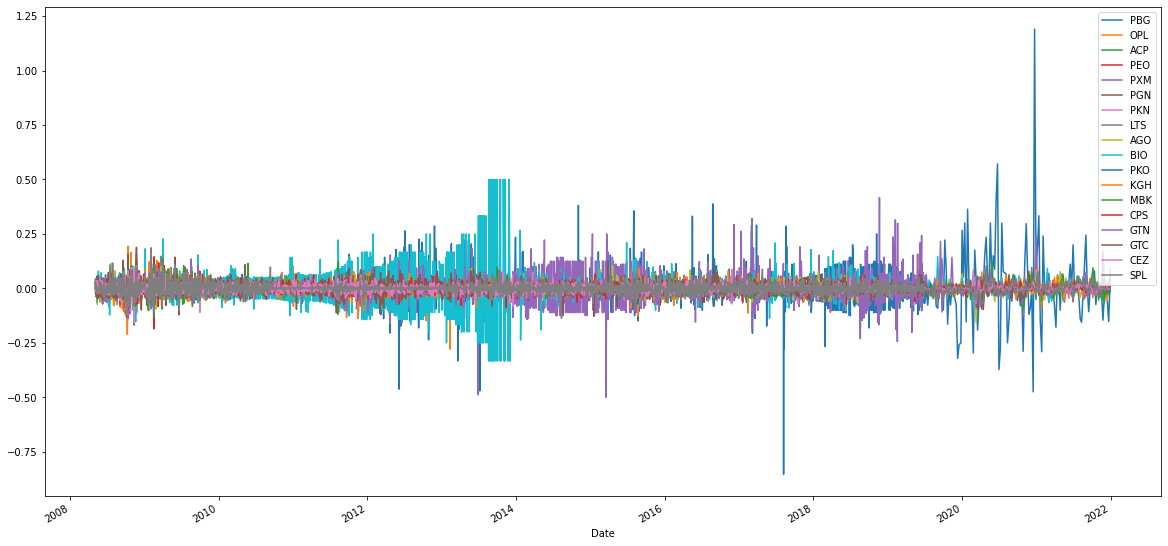

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
df.plot(ax=ax)
plt.show()

## Mean and standard deviation of daily returns

In [ ]:
mean_std_df = df.agg(["mean", "std"]).transpose()

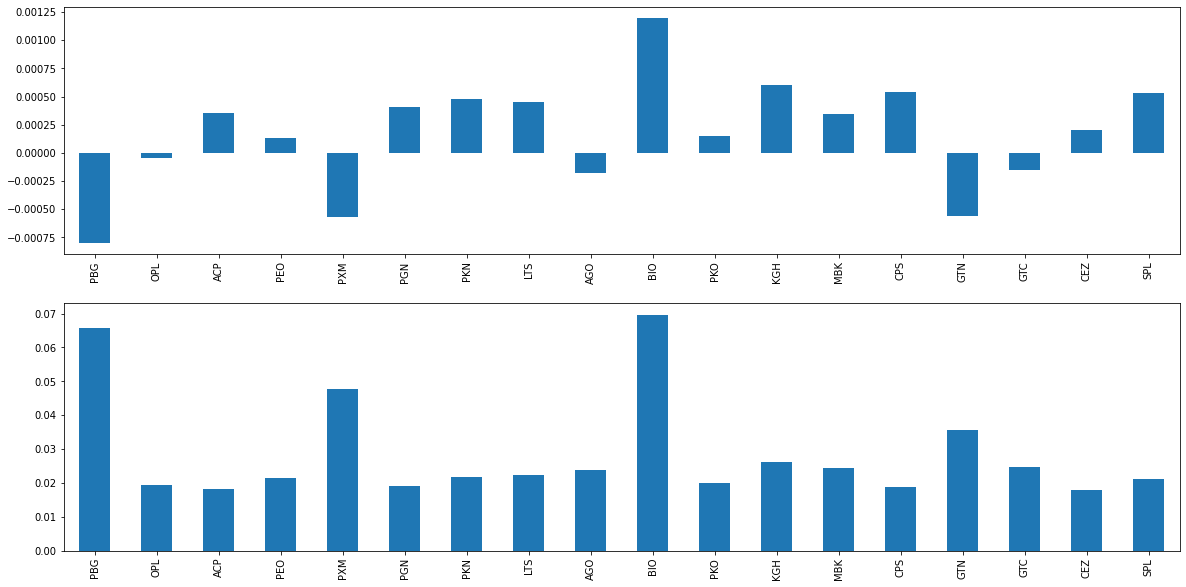

In [ ]:
fig, axs = plt.subplots(2, figsize=(20, 10))
mean_std_df["mean"].plot(kind="bar", ax=axs[0])
mean_std_df["std"].plot(kind="bar", ax=axs[1])
plt.show()

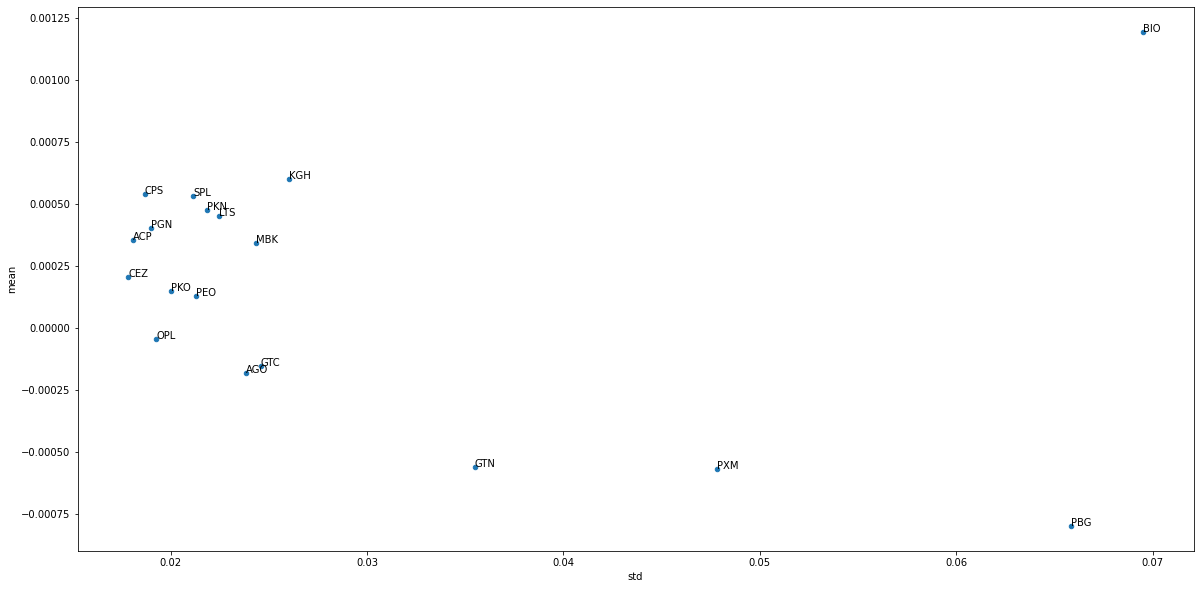

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
mean_std_df.plot("std", "mean", kind="scatter", ax=ax)

for _, row in mean_std_df.iterrows():
    ax.annotate(row.name, (row["std"], row["mean"]))

plt.show()

## Correlation matrix of daily returns

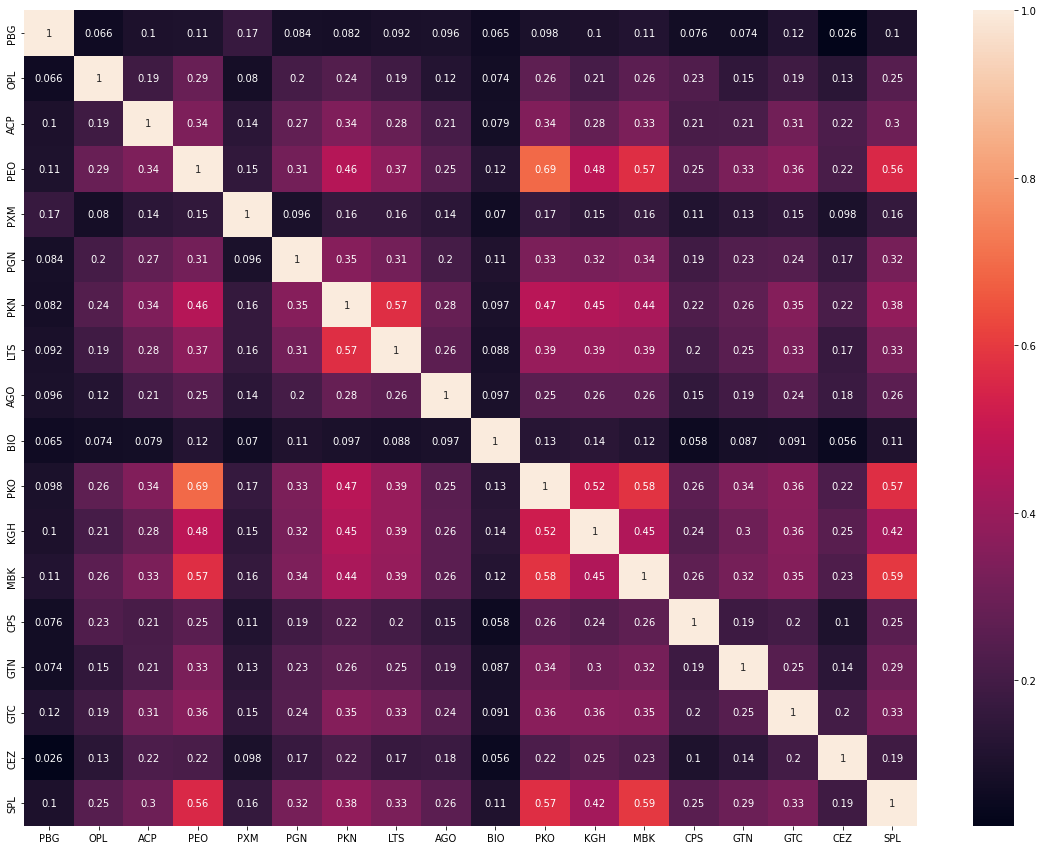

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(df.corr(), ax=ax, annot=True)
plt.show()

## Modern portfolio theory

In [ ]:
from qpsolvers import solve_qp

In [ ]:
SIGMA = df.cov().to_numpy()
R = df.mean().to_numpy()

In [ ]:
def get_weights(q):
    return solve_qp(2 * SIGMA, -q * R, None, None, np.ones_like(R), np.ones(1))

def get_nonnegative_weights(q):
    return solve_qp(2 * SIGMA, -q * R, None, None, np.ones_like(R), np.ones(1), np.zeros_like(R))

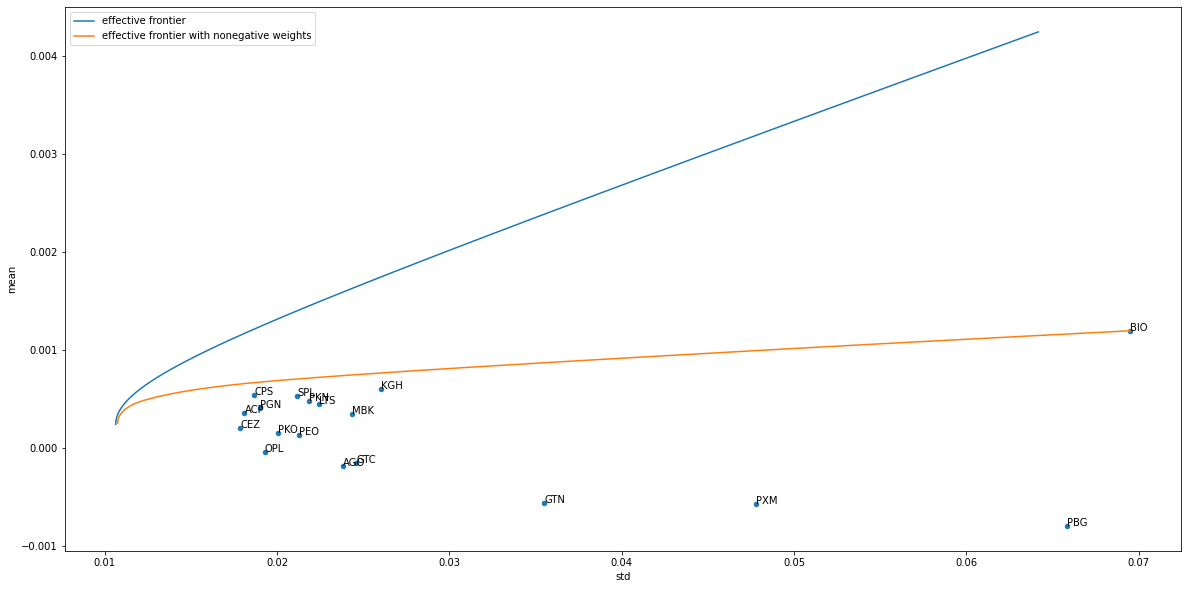

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
mean_std_df.plot("std", "mean", kind="scatter", ax=ax)

for _, row in mean_std_df.iterrows():
    ax.annotate(row.name, (row["std"], row["mean"]))

arr = []
for q in np.linspace(0, 2, 100):
    w = get_weights(q)
    vol, ret = np.sqrt(w.T @ SIGMA @ w), np.dot(R, w)
    arr.append([vol, ret])

nonneg_arr = []
for q in np.linspace(0, 30, 10000):
    w = get_nonnegative_weights(q)
    vol, ret = np.sqrt(w.T @ SIGMA @ w), np.dot(R, w)
    nonneg_arr.append([vol, ret])

arr = np.array(arr)
nonneg_arr = np.array(nonneg_arr)
ax.plot(arr[:, 0], arr[:, 1], label="effective frontier")
ax.plot(nonneg_arr[:, 0], nonneg_arr[:, 1], label="effective frontier with nonegative weights")
ax.legend()
plt.show()

# Experiments with NSGA2

In [ ]:
from nsga2.objectives import get_objective, portfolios_neg_returns, portfolios_vars
from nsga2.model import NSGA2

from functools import partial

In [ ]:
objective = get_objective(
    partial(portfolios_neg_returns, R=R),
    partial(portfolios_vars, SIGMA=SIGMA),
)

In [ ]:
model = NSGA2(len(R), 500, 500)

In [ ]:
history = model.simulate(objective)

100%|██████████| 500/500 [00:40<00:00, 12.33it/s]


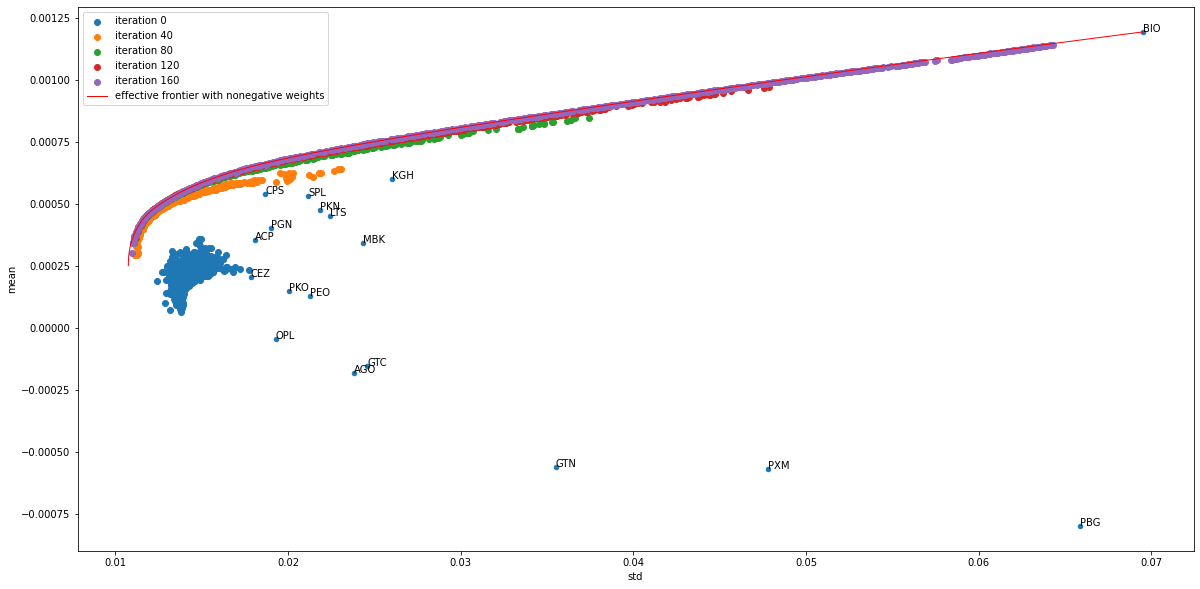

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
mean_std_df.plot("std", "mean", kind="scatter", ax=ax)
for _, row in mean_std_df.iterrows():
    ax.annotate(row.name, (row["std"], row["mean"]))

for n in range(0, 200, 40):
    ax.scatter(np.sqrt(history[n, :, 1]), -history[n, :, 0], label=f"iteration {n}")

ax.plot(nonneg_arr[:, 0], nonneg_arr[:, 1], label="effective frontier with nonegative weights", c="red", linewidth=1)

ax.legend()
plt.show()